### Re-organize results collected from AMT

- Original file format:
> source_hits_file and target_hits_file <br>
> n_hits * (n_amt/hit) <br>

#### 1. Aggregate AMT effect (mean, mean remove max and min, median, most common)<br>
> Organize by (word pair, sentence pair, list of source ratings, list of target ratings) <br>

#### 2. Correlations between each aggregated AMT effect <br>
#### 3. Correlations between each treatment effect and AMT effect, roc curve <br>
> treatment effect: KNN, VT, CTF, CSF <br>
> AMT effect: mean, median, mostcommon, mean remove max min <br>
> truth: determine by sign of AMT effect <br>
> Percentage of 0 for mean, median AMT effects <br>

#### 4. Inter-annotator aggreement <br>

In [75]:
from collections import Counter
from IPython.display import display
from scipy.stats import pearsonr,spearmanr
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
import pandas as pd
import re, ast
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

label2rating = {
    'category 1': 5,
    'category 2': 4,
    'category 3': 3,
    'category 4': 2,
    'category 5': 1,
}
#aggregate_columns = ['rating_mean', 'rating_median', 'rating_std', 'rating_mostcom','rating_max', 'rating_min', 'rating_count']
amt_effect_list = ['amt_effect_mean','amt_effect_median','amt_effect_mostcom','amt_effect_mean_rmOut']
my_method_columns = ['csf_effect', 'ctf_effect', 'knn_effect', 'vt_effect']
full_name = {'yp':'Yelp','tw':'Twitter','airbnb':'Airbnb'}
method_columns = ['csf_effect_target', 'Input.ctf_effect_target', 'Input.knn_effect_target', 'Input.vt_effect_target']
data_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/6_amt/'

#### 1. Aggregate AMT effect (mean, mean remove max and min, median, most common)
> Organize by (word pair, sentence pair, list of source ratings, list of target ratings)

In [2]:
def find_dummy_idx(row):
    # which question is dummy?
    for k,v in row.to_dict().items():
        if v == 'DUMMY':
            return int(re.findall('_([0-9]+)', k)[0])
    return -1

In [3]:
def is_valid_result(row):
    """
    If dummy true label is 1, answer must be 4 or 5
    If dummy true label is 0, answer must be 1 or 2
    Otherwise, invalid.
    """
    dummy_idx = find_dummy_idx(row)
    dummy_truth = row['Input.true_y_%d' % dummy_idx]
    dummy_rating = label2rating[row['Answer.categories_%d' % dummy_idx]]
    return (dummy_truth == 0 and dummy_rating < 3) or (dummy_truth == 1 and dummy_rating > 3)

In [4]:
def my_get_mostcomm(rate_list):
    """
    Return the most common rating for each sentence:
        [1,1,1,2,2,2] returns 1.5
        [1,1,1] returns 1
        [1] returns 1
    """
    rate_ct = Counter(rate_list)
    if(len(rate_ct)>1):
        if(rate_ct.most_common(2)[0][1] == rate_ct.most_common(2)[1][1]):
            return (rate_ct.most_common(2)[0][0]+rate_ct.most_common(2)[1][0])/2
        else:
            return rate_ct.most_common(1)[0][0]
    else:
        return rate_ct.most_common(1)[0][0]

In [5]:
def my_splitHit_bysent(hit_pd,flag):
    """
    Parameters:
        DataFrame of hit file, flag to indicate weather it is source hits or target hits
    Function:
        Iterating over every hit, split one hit into sentences
    Return:
        DataFrame with each row records rating info for each sentence
    """
    
    sent_info = []
    n_invalid = 0
    for idx,row in hit_pd.iterrows():
        # Check if the current hit is valid 
        if(is_valid_result(row)):
            for i in range(11):
                samp_dict={}
                samp_dict['source']=row['Input.source_'+str(i)]
                samp_dict['target']=row['Input.target_'+str(i)]
                samp_dict['org_sentence']=row['Input.src_sentence_'+str(i)]
                samp_dict[flag+'_sentence']=row['Input.sentence_to_label_'+str(i)]
                samp_dict[flag+'_ratings']=row['Answer.categories_'+str(i)]
                sent_info.append(samp_dict)
        else:
            n_invalid += 1
            continue
    
    return pd.DataFrame(sent_info),n_invalid

In [6]:
def my_aggregate_result(data_path):
    """
    Get summary src ratings and target ratings for each (word pair, sentence pair)
    """
    for ii, data_name in enumerate(['yp', 'tw', 'airbnb']):
        summary_info = []
        Tolabel_df = pd.read_csv(data_path+'hits/%s_join.csv' % data_name)
        src_res_df = pd.read_csv(data_path+'results/%s_src_hits_results.csv' % data_name)
        tar_res_df = pd.read_csv(data_path+'results/%s_target_hits_results.csv' % data_name)
        
        # Only record valid hits
        src_sent_pd,n_src_invalid = my_splitHit_bysent(src_res_df,flag='src')
        tar_sent_pd,n_tar_invalid = my_splitHit_bysent(tar_res_df,flag='tar')
        print("%s: (%d / %d) invalid hits in source and (%d / %d) in target" % (full_name[data_name],n_src_invalid,src_res_df.shape[0],n_tar_invalid,tar_res_df.shape[0]))
        
        #src_tar_pd = src_res_pd.merge(tar_res_pd,on=['source','target','org_sentence'],how='left')
                
        for idx, row in Tolabel_df.iterrows():
            new_row = row.to_dict()
            src_rate_pd = src_sent_pd[(src_sent_pd.source==row.source)&(src_sent_pd.target==row.target)&
                                     (src_sent_pd.org_sentence==row.src_sentence)&(src_sent_pd.src_sentence==row.src_sentence)]
            tar_rate_pd = tar_sent_pd[(tar_sent_pd.source==row.source)&(tar_sent_pd.target==row.target)&
                                     (tar_sent_pd.org_sentence==row.src_sentence)&(tar_sent_pd.tar_sentence==row.tar_sentence)]
            
            src_rates = [label2rating[catg] for catg in src_rate_pd['src_ratings'].values]
            tar_rates = [label2rating[catg] for catg in tar_rate_pd['tar_ratings'].values]
            
            new_row['src_ratings'] = sorted(src_rates)
            new_row['tar_ratings'] = sorted(tar_rates)
            new_row['amt_effect_mean'] = np.mean(tar_rates) - np.mean(src_rates)
            new_row['amt_effect_median'] = np.median(tar_rates) - np.median(src_rates)
            new_row['amt_effect_mostcom'] = my_get_mostcomm(tar_rates) - my_get_mostcomm(src_rates)
            
            
            summary_info.append(new_row)
        
        pd.DataFrame(summary_info).to_csv(data_path+'results/'+data_name+'_result_summary.csv',columns=['source','target',
                                        'src_sentence','tar_sentence','knn_effect','vt_effect','ctf_effect','csf_effect',
                                        'true_y','id','src_ratings','tar_ratings',
                                        'amt_effect_mean','amt_effect_median','amt_effect_mostcom'],index=False)

In [121]:
my_aggregate_result(data_path)

Yelp: (2 / 120) invalid hits in source and (1 / 120) in target
Twitter: (1 / 120) invalid hits in source and (4 / 120) in target
Airbnb: (19 / 132) invalid hits in source and (6 / 112) in target


In [186]:
def adding_column(data_path):
    for data_name in ['yp', 'tw', 'airbnb']:
        sum_pd = pd.read_csv(data_path+'results/'+data_name+'_result_summary_nodummy.csv')
        sum_pd['amt_effect_mean_rmOut'] = sum_pd.tar_ratings.apply(lambda x: np.mean(ast.literal_eval(x)[1:-1])) - sum_pd.src_ratings.apply(lambda x: np.mean(ast.literal_eval(x)[1:-1]))
        pd.DataFrame(sum_pd).to_csv(data_path+'results/'+data_name+'_result_summary_rmOut.csv',columns=['source','target',
                                        'src_sentence','tar_sentence','knn_effect','vt_effect','ctf_effect','csf_effect',
                                        'true_y','id','src_ratings','tar_ratings',
                                        'amt_effect_mean','amt_effect_median','amt_effect_mostcom','amt_effect_mean_rmOut'],index=False)

In [187]:
adding_column(data_path)

#### 2. Correlations between each aggregated AMT effect

In [6]:
def amtEffects_corr(data_path,amt_effect_list):
    """
    Calculate pearsonr correlation between each amt effect (mean, median, mostcommon)

    """
    for ii, data_name in enumerate(['yp', 'tw', 'airbnb']):
        data_pd = pd.read_csv(data_path+'results/'+data_name+'_result_summary_rmOut.csv')
        print(full_name[data_name])
        display(data_pd[amt_effect_list].corr(method='pearson'))
        

In [192]:
amtEffects_corr(data_path,amt_effect_list)

Yelp


,amt_effect_mean,amt_effect_median,amt_effect_mostcom,amt_effect_mean_rmOut
amt_effect_mean,1.000000,0.947099,0.876535,0.993767
amt_effect_median,0.947099,1.000000,0.932349,0.957991
amt_effect_mostcom,0.876535,0.932349,1.000000,0.902162
amt_effect_mean_rmOut,0.993767,0.957991,0.902162,1.000000


Twitter


,amt_effect_mean,amt_effect_median,amt_effect_mostcom,amt_effect_mean_rmOut
amt_effect_mean,1.000000,0.866253,0.777801,0.989438
amt_effect_median,0.866253,1.000000,0.879963,0.888183
amt_effect_mostcom,0.777801,0.879963,1.000000,0.821059
amt_effect_mean_rmOut,0.989438,0.888183,0.821059,1.000000


Airbnb


,amt_effect_mean,amt_effect_median,amt_effect_mostcom,amt_effect_mean_rmOut
amt_effect_mean,1.000000,0.706865,0.476551,0.923269
amt_effect_median,0.706865,1.000000,0.763087,0.752257
amt_effect_mostcom,0.476551,0.763087,1.000000,0.592968
amt_effect_mean_rmOut,0.923269,0.752257,0.592968,1.000000


#### 3. Correlations between each treatment effect and AMT effect, roc curve
> treatment effect: KNN, VT, CTF, CSF <br>
> AMT effect: mean, median, mostcommon, mean remove max min <br>
> truth: determine by sign of AMT effect <br>
> Percentage of 0 for each AMT effect (median, mostcommon)

In [7]:
def object_amt_corr(df, data_name, flag_method_columns, amt_effect, how='pearson'):
    """
    Function:
        Calculate correlation between each objective methods (KNN,VT,CTF,CSF) with amt perception.
    Return:
        DataFrame with objective methods as index, and dataset name as column name.
    """
    # how=pearson|spearman
    #for method_name in method_columns:
    #    df[method_name] = [float(x) for x in df[method_name]]
#    corrs = df[method_columns].corrwith(df['amt_effect'])
    corrs = df[flag_method_columns].apply(lambda col: col.corr(df[amt_effect], method=how), axis=0)
    return pd.DataFrame(corrs, columns=[full_name[data_name]])

In [290]:
def amt0_percent(data_path):
    """
        Percentage of 0 AMT treatment effects
    """
    data_perct0 = []
    for data_name in ['yp','tw','airbnb']:
        perct0 = {}
        data_pd = pd.read_csv(data_path+'results/%s_result_summary_nodummy.csv' % data_name)
        perct0['median'] = '%.3f%%' % (round(float(Counter(data_pd['amt_effect_median'].values)[0]/data_pd.shape[0]),5)*100)
        perct0['mostcommon'] = '%.3f%%' % (round(float(Counter(data_pd['amt_effect_mostcom'].values)[0]/data_pd.shape[0]),5)*100)
        data_perct0.append(pd.Series(perct0))
        
    display(pd.concat(data_perct0,axis=1,keys=[full_name[name] for name in ['yp','tw','airbnb']]))

In [291]:
amt0_percent(data_path)

,Yelp,Twitter,Airbnb
median,28.333%,40.000%,60.833%
mostcommon,34.167%,37.500%,60.833%


In [ ]:
# Not in use
def get_truth(df):
    """
    First check median and then check mean
    """
    truth = []
    for idx,rowx in df[['amt_effect_median','amt_effect_mean']].iterrows():
        if(rowx.amt_effect_median>0):
            truth.append(1)
        elif(rowx.amt_effect_median<0):
            truth.append(0)
        elif(rowx.amt_effect_median == 0):
            if(rowx.amt_effect_mean > 0):
                truth.append(1)
            elif(rowx.amt_effect_mean <= 0):
                truth.append(0)
            
    return np.array(truth)

In [9]:
def my_roc(df, data_name, flag_method_columns,amt_effect, ax):
    """
    Plot roc curve and calculate auc roc
    """
    # How to define truth
    truth = np.array([1 if x > 0 else 0 for x in df[amt_effect]]) # truth include amt_effect=0
    
    auc_score = []
    linecycler = cycle(['b-', 'g--', 'r-.', 'c:'])
    labels = ['CSF', 'CF-RF', 'KNN', 'VT-RF']
    for i in range(len(flag_method_columns)):
        #fpr, tpr, _ = roc_curve(truth, df[method_columns[i]])
        fpr, tpr, _ = roc_curve(truth, df[flag_method_columns[i]])
        ax.plot(fpr, tpr, next(linecycler), alpha=0.8, label=labels[i],linewidth=1.0)#pretty_name(method)
        auc_score.append(roc_auc_score(truth, df[flag_method_columns[i]]))
    
    ax.set_title(data_name)
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=.8)
    return pd.DataFrame(auc_score, index=labels, columns=[full_name[data_name]])

In [12]:
def my_roc_rm0(df, data_name, amt_effect, ax):
    """
    Throw instances with 0 AMT effects and only consider:
    AMT_effect > 0, truth = 1, AMT_effect < 0, truth = 0
    Plot roc curve and calculate auc roc
    """
    # How to define truth
    
    remain_idx = df[df[amt_effect] !=0].index
    truth = np.array([1 if x > 0 else 0 for x in df.iloc[remain_idx][amt_effect]]) # truth remove amt_effect=0
    
    auc_score = []
    linecycler = cycle(['b-', 'g--', 'r-.', 'c:'])
    labels = ['CSF', 'CF-RF', 'KNN', 'VT-RF']
    for i in range(len(my_method_columns)):
        #fpr, tpr, _ = roc_curve(truth, df[my_method_columns[i]])
        fpr, tpr, _ = roc_curve(truth, df.iloc[remain_idx][my_method_columns[i]])
        ax.plot(fpr, tpr, next(linecycler), alpha=0.8, label=labels[i],linewidth=1.0)#pretty_name(method)
        auc_score.append(roc_auc_score(truth, df.iloc[remain_idx][my_method_columns[i]]))
    
    ax.set_title(data_name)
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=.8)
    return pd.DataFrame(auc_score, index=labels, columns=[full_name[data_name]])

In [19]:
def my_analyze(data_path,flag_method_columns,amt_effect):
    """
    Function:
        Calculate correlations between (objective,perception) and roc curve (truth=perception, prob=objective) using a specific
        aggregated amt_effect.
    """
    all_corrs = []
    all_rocs = []

    fig, axes = plt.subplots(1, 3, figsize=(10,3), linewidth=2.0, sharex=True, sharey=True)
    
    for ii, data_name in enumerate(['yp', 'tw', 'airbnb']):
        #src_tar_df = pd.read_csv(data_path+'results/%s_result_summary_agree.csv' % data_name)
        src_tar_df = pd.read_csv(project_path+'V2_'+full_name[data_name].lower()+'/8_Var/'+data_name+'_effect_leaf10.csv')
        src_tar_df = src_tar_df.fillna(0)
        all_corrs.append(object_amt_corr(src_tar_df, data_name,flag_method_columns, amt_effect))
        all_rocs.append(my_roc(src_tar_df, data_name, flag_method_columns, amt_effect, axes[ii]))
        #all_rocs.append(my_roc_rm0(src_tar_df, data_name, amt_effect, axes[ii]))

    axes[1].set_xlabel('False positive rate', size=14)
    axes[0].set_ylabel('True positive rate', size=14)
    axes[0].legend(loc='best')
    
    plt.tight_layout()
    #plt.savefig('AMTplot.png')
    plt.show()
    
    rocs_df = pd.concat(all_rocs, axis=1)
    rocs_df['Mean'] = rocs_df.mean(axis=1)
    print('AUC ROC for %s' % amt_effect)
    display(rocs_df.sort_values('Mean', ascending=False))
    
    corrs_df = pd.concat(all_corrs, axis=1)
    corrs_df['Mean'] = corrs_df.mean(axis=1)
    print('correlations with  %s' % amt_effect)
    display(corrs_df.sort_values('Mean', ascending=False))

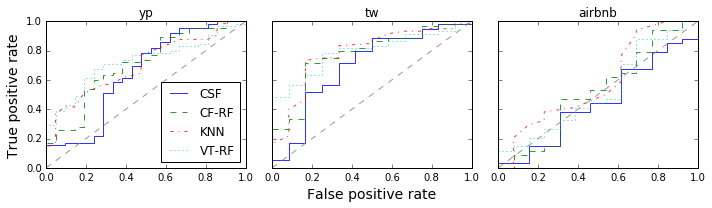

AUC ROC for amt_effect_median


,Yelp,Twitter,Airbnb,Mean
KNN,0.700733,0.786111,0.585973,0.690939
VT-RF,0.728938,0.795833,0.522624,0.682465
CF-RF,0.707692,0.770833,0.520362,0.666296
CSF,0.650549,0.698611,0.452489,0.600550


correlations with  amt_effect_median


,Yelp,Twitter,Airbnb,Mean
ctf_effect,0.574401,0.274435,0.010226,0.286354
vt_effect,0.508452,0.266533,0.023989,0.266325
csf_effect,0.531100,0.219648,-0.019324,0.243808
knn_effect,0.379141,0.233383,0.061917,0.224814


In [327]:
my_analyze(data_path,my_method_columns,amt_effect='amt_effect_median')

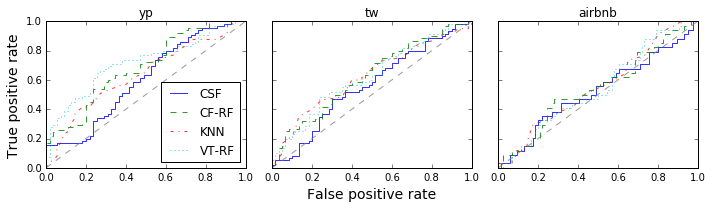

correlations with  amt_effect_median


,Yelp,Twitter,Airbnb,Mean
ctf_effect,0.574401,0.274435,0.010226,0.286354
vt_effect,0.508452,0.266533,0.023989,0.266325
csf_effect,0.531100,0.219648,-0.019324,0.243808
knn_effect,0.379141,0.233383,0.061917,0.224814


AUC ROC for amt_effect_median


,Yelp,Twitter,Airbnb,Mean
VT-RF,0.719720,0.623056,0.547880,0.630218
CF-RF,0.689510,0.628889,0.549932,0.622777
KNN,0.634965,0.622917,0.552155,0.603345
CSF,0.604755,0.565000,0.526676,0.565477


In [197]:
my_analyze(data_path,amt_effect='amt_effect_median') # correct one

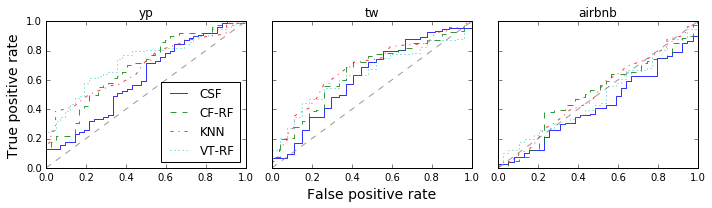

correlations with  amt_effect_mean


,Yelp,Twitter,Airbnb,Mean
ctf_effect,0.549065,0.206454,-0.031848,0.241224
vt_effect,0.515353,0.249676,-0.066485,0.232848
csf_effect,0.495432,0.149120,-0.037296,0.202419
knn_effect,0.356213,0.188479,-0.003220,0.180490


AUC ROC for amt_effect_mean


,Yelp,Twitter,Airbnb,Mean
KNN,0.686813,0.678614,0.509655,0.625027
VT-RF,0.728022,0.643967,0.486546,0.619512
CF-RF,0.689255,0.652330,0.502058,0.614548
CSF,0.608974,0.622859,0.428300,0.553378


In [196]:
my_analyze(data_path,amt_effect='amt_effect_mean')

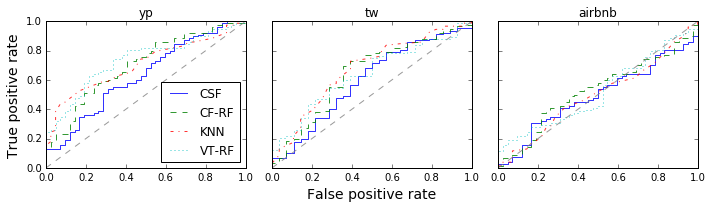

correlations with  amt_effect_mean_rmOut


,Yelp,Twitter,Airbnb,Mean
ctf_effect,0.563518,0.234953,-0.011360,0.262370
vt_effect,0.513451,0.278476,-0.035892,0.252012
csf_effect,0.501357,0.171440,-0.019478,0.217773
knn_effect,0.373695,0.193150,0.007826,0.191557


AUC ROC for amt_effect_mean_rmOut


,Yelp,Twitter,Airbnb,Mean
VT-RF,0.736569,0.641693,0.521978,0.633413
CF-RF,0.704823,0.646739,0.527778,0.626447
KNN,0.706044,0.672943,0.496337,0.625108
CSF,0.632784,0.599379,0.495116,0.575760


In [195]:
my_analyze(data_path,amt_effect='amt_effect_mean_rmOut')

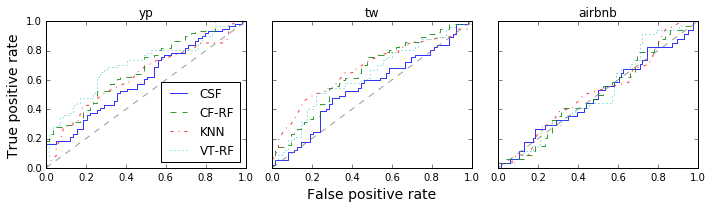

correlations with  amt_effect_mostcom


,Yelp,Twitter,Airbnb,Mean
ctf_effect,0.572622,0.261288,0.005867,0.279926
vt_effect,0.492134,0.200622,0.018279,0.237012
knn_effect,0.370245,0.204642,0.038726,0.204538
csf_effect,0.527268,0.143541,-0.057436,0.204458


AUC ROC for amt_effect_mostcom


,Yelp,Twitter,Airbnb,Mean
VT-RF,0.703251,0.630744,0.519152,0.617715
CF-RF,0.679911,0.653300,0.508892,0.614034
KNN,0.627119,0.673629,0.519152,0.606633
CSF,0.607113,0.552214,0.502052,0.553793


In [160]:
my_analyze(data_path,amt_effect='amt_effect_mostcom')

#### Result for instances where true_y agree with label inferred by amt rating for source sentence
- Not useful, we only care about whether target word increase p(x=1) for source sentence, not care about whether source sentence is positive or negative. In other words, we only care about if substituting source word in source sentence by target word increases AMT perception (rating for using target word - rating for using source word)

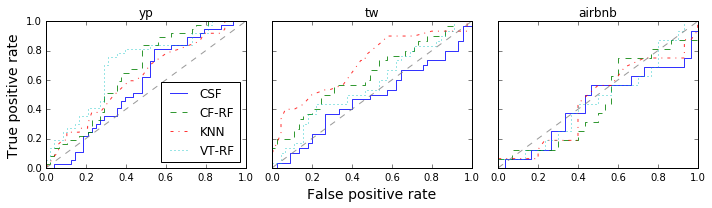

AUC ROC for amt_effect_mostcom


,Yelp,Twitter,Airbnb,Mean
KNN,0.615709,0.711481,0.459375,0.595522
CF-RF,0.662162,0.637778,0.452083,0.584008
VT-RF,0.702140,0.574074,0.464583,0.580266
CSF,0.573198,0.476296,0.439583,0.496359


correlations with  amt_effect_mostcom


,Yelp,Twitter,Airbnb,Mean
ctf_effect,0.350504,0.233697,-0.177028,0.135724
vt_effect,0.329374,0.150235,-0.072951,0.135553
knn_effect,0.258281,0.318518,-0.174553,0.134082
csf_effect,0.175057,-0.026539,-0.251354,-0.034279


In [15]:
my_analyze(data_path,amt_effect='amt_effect_mostcom')

#### AUC ROC and correlation for min_samples_leaf=10

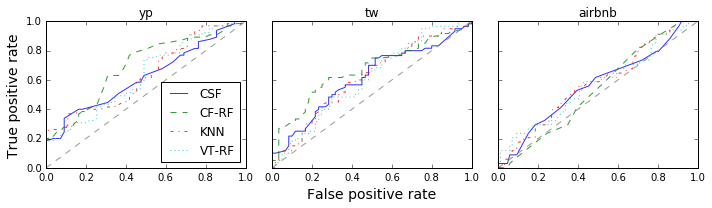

AUC ROC for amt_effect_median


,Yelp,Twitter,Airbnb,Mean
CF-RF,0.693147,0.669167,0.534029,0.632114
KNN,0.636084,0.613750,0.577120,0.608985
VT-RF,0.630210,0.608056,0.569425,0.602564
CSF,0.622378,0.610556,0.563098,0.598677


correlations with  amt_effect_median


,Yelp,Twitter,Airbnb,Mean
vt_effect_leaf10,0.740782,0.320637,0.048910,0.370109
csf_effect_200leaf10,0.628729,0.320763,0.096409,0.348634
ctf_effect_leaf10,0.663759,0.262574,0.108634,0.344989
knn_effect_sim0,0.458666,0.268802,0.075876,0.267781


In [20]:
project_path = '/data/2/zwang/2018_S_WordTreatment/'
full_name = {'yp':'Yelp','tw':'Twitter','airbnb':'Airbnb'}
new_method_columns = ['knn_effect_sim0', 'vt_effect_leaf10', 'ctf_effect_leaf10', 'csf_effect_200leaf10']
my_analyze(data_path,new_method_columns,amt_effect='amt_effect_median')

#### 4. Inter-annotator aggreement

In [1]:
def organize_HIT_byuser(data_path):
    """
    Each hit is labeled by 10 or 11 users, reorganize and prepare for inter-annotator agreement
    """
    for ii, data_name in enumerate(['yp', 'tw', 'airbnb']):
        all_hits = []
        src_hit_df = pd.read_csv(data_path+'results/%s_src_hits_results.csv' % data_name)
        tar_hit_df = pd.read_csv(data_path+'results/%s_target_hits_results.csv' % data_name)
        hit_df = pd.concat([src_hit_df,tar_hit_df])
        
        hit_gp = hit_df.groupby('HITId')
        for hitid,hitusers in hit_gp:
            one_hit = {}
            one_hit['hit_id'] = hitid
            user_ct = -1
            for idx,user in hitusers.iterrows():
                user_ct += 1
                one_hit['user_'+str(user_ct)] = []
                
                if(is_valid_result(user)):
                    for i in range(11):
                        one_hit['user_'+str(user_ct)].append(label2rating[user['Answer.categories_%d' % i]])
            
            all_hits.append(one_hit)
        
        user_cols = []
        for i in range(11):
            user_cols.append('user_%d' % i)
        pd.DataFrame(all_hits).to_csv(data_path+'results/%s_hit_byuser.csv' % data_name, columns=['hit_id']+user_cols, index=False)

In [70]:
def binarize_rating(data_path):
    """
    Make 1~5 scale to 1(negative), 2(neutral), 3(positive)
    """
    for ii, data_name in enumerate(['yp','tw','airbnb']): #'yp', 'tw',
        hit_df = pd.read_csv(data_path+'results/%s_hit_byuser.csv' % data_name)
        hit_info = []
        for idx,row in hit_df.iterrows():
            row_info = {}
            row_info['hit_id'] = row['hit_id']
            for i in range(11):
                if(isinstance(row['user_'+str(i)],str)): # twitter and yelp are empty for user_10
                    useri_rates = ast.literal_eval(row['user_'+str(i)])
                    if(len(useri_rates) > 0): # dummy users are []
                        binarize_rates = []
                        for r in useri_rates:
                            if(r<3):
                                binarize_rates.append(1)
                            elif(r == 3):
                                binarize_rates.append(2)
                            elif(r > 3):
                                binarize_rates.append(3)
                        row_info['user_'+str(i)] = binarize_rates
                    else:
                        row_info['user_'+str(i)] = []
                else:
                    row_info['user_'+str(i)]=[]
           
            hit_info.append(row_info)
        pd.DataFrame(hit_info).to_csv(data_path+'results/%s_hit_byuser_binarize.csv' % data_name,index=False)

In [71]:
binarize_rating(data_path)

In [110]:
def cal_inner_agree(data_path):
    """
    Revised
    Calculate inter-annotator agreement by averaging over correlations of every two users for a same hit,
    and then average over all hits.
    """
    for ii, data_name in enumerate(['yp','tw','airbnb']): 
        hit_df = pd.read_csv(data_path+'results/%s_hit_byuser.csv' % data_name)
        corr_pear = []
        corr_spear = []
        for idx,row in hit_df.iterrows():
            row_corr_pear = []
            row_corr_spear = []
            for i in range(11):
                if(isinstance(row['user_'+str(i)],str)): # twitter and yelp are empty for user_10
                    useri_rates = ast.literal_eval(row['user_'+str(i)])
                    if(len(useri_rates) > 0): # dummy users are []
                        for j in range(i+1,11):
                            if(isinstance(row['user_'+str(j)],str)):
                                userj_rates = ast.literal_eval(row['user_'+str(j)])
                                if(len(userj_rates) > 0):
                                    #print(useri_rates,userj_rates,pearsonr(useri_rates,userj_rates)[0])
#                                     print(i,j)
                                    row_corr_pear.append(pearsonr(useri_rates,userj_rates)[0])
                                    row_corr_spear.append(spearmanr(useri_rates,userj_rates)[0])
            
            # replace nan values to 1 ? Need to decide
#             row_corr_pear = [1.0 if np.isnan(pv) else pv for pv in row_corr_pear]
#             row_corr_spear = [1.0 if np.isnan(pv) else pv for pv in row_corr_spear]
            
            corr_pear.append(np.nanmean(row_corr_pear))
            corr_spear.append(np.nanmean(row_corr_spear))
        
        print(data_name,'%.3f' % (np.nanmean(corr_pear)), '%.3f' % (np.nanmean(corr_spear)))

            #print(corr_pear,corr_spear)

In [103]:
# result with 1~5 scales with nan replaced by 1.0
cal_inner_agree(data_path)

yp 0.5627844745008951 0.5402494337475373
tw 0.5760676194680124 0.5643414644505002
airbnb 0.5570191217724928 0.45141707773815165


In [105]:
# result with 1~3 scales with nan replaced by 1.0
cal_inner_agree(data_path)

yp 0.45361085061101325 0.4436404644643443
tw 0.4846876657961238 0.47958928717996496
airbnb 0.7385715209082971 0.7057437413419182


In [5]:
# correlation with 1~5 scales ignore nan 
cal_inner_agree(data_path)

yp 0.557301951082 0.535081343847
tw 0.576067619468 0.564341464451
airbnb 0.51355547995 0.407878944078


In [109]:
# correlation with 1~3 scales ignore nan 
cal_inner_agree(data_path)

yp 0.4462252631757871 0.43621932416566284
tw 0.47952528786473475 0.47416723388446563
airbnb 0.5839243707506975 0.5504194026917623


In [111]:
pearsonr([5, 4, 4, 5, 2, 3, 5, 5, 4, 4, 4],[4, 1, 4, 2, 1, 2, 1, 3, 2, 2, 2])[0]

0.375

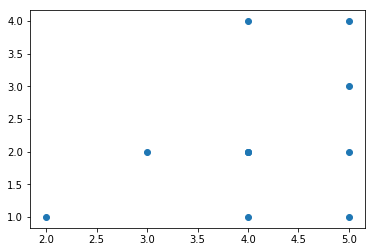

In [114]:
plt.scatter([5, 4, 4, 5, 2, 3, 5, 5, 4, 4, 4],[4, 1, 4, 2, 1, 2, 1, 3, 2, 2, 2])

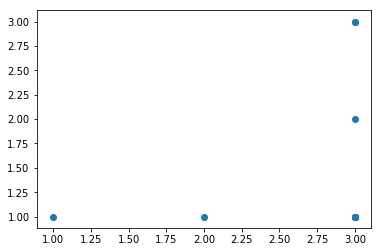

In [116]:
plt.scatter([3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3],[3, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1])

In [117]:
pearsonr([3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3],[3, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1])[0]

0.2570966888216479

#### Check how does evaluation results change with different parameters
- Parameters for 4 treatment effect estimation methods: KNN: K and similarity thresholds; VT, CTF, CSF: minimum instances in each leaf <br>
- How does auc roc score change with different parameters <br>
- How does correlation (treatment effect, AMT) change with different parameters <br>

In [14]:
project_path = '/data/2/zwang/2018_S_WordTreatment/'

In [ ]:
from scipy.stats import pearsonr

In [181]:
def param_eval_knn(project_path,flag_method_columns,amt_effect,eval_method):
    """
    Function:
        Calculate how does roc curve (truth=perception, prob=objective) change with different parameters.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18,3), linewidth=2.0, sharex=True, sharey=True)
    
    for ii, data_name in enumerate(['yp', 'tw', 'airbnb']):
        src_tar_df = pd.read_csv(project_path+'V2_'+full_name[data_name].lower()+'/8_Var/'+data_name+'_effect_paramvari.csv')
        truth = np.array([1 if x > 0 else 0 for x in src_tar_df[amt_effect]]) # truth include amt_effect=0
        
        knn_roc = {}
        
        for mknn in ['knn_effect_sim00','knn_effect_sim05','knn_effect_sim10','knn_effect_sim15','knn_effect_sim20']:
            knn_df = src_tar_df[mknn].apply(lambda x: x[1:-1].split())
            knn_arr = []
            for row in knn_df:
                row_items = []
                for i in range(len(row)):
                    if(row[i] != 'nan'):
                        row_items.append(float(row[i]))
                    else:
                        row_items.append(0.0)
                knn_arr.append(row_items)
            knn_arr = np.array(knn_arr)
            
            knn_roc[mknn.split('_')[-1]]=[]
            for coli in range(knn_arr.shape[1]):
                if(eval_method == 'roc_auc'):
                    knn_roc[mknn.split('_')[-1]].append(roc_auc_score(truth,knn_arr[:,coli]))
                elif(eval_method == 'pearson'):
                    knn_roc[mknn.split('_')[-1]].append(pearsonr(truth,knn_arr[:,coli])[0])
        
        axes[ii].set_title(full_name[data_name])
        axes[ii].set_xticks([i for i in range(knn_arr.shape[1])])
        axes[ii].set_xticklabels([i for i in range(10, 105, 5)])
    
        for sim in knn_roc:
            axes[ii].plot(knn_roc[sim],marker='o', linestyle='-',label=sim)

    axes[1].set_xlabel('k (# neighbors)', size=14)
    if(eval_method == 'roc_auc'):
        axes[0].set_ylabel('auc roc score', size=14)
    elif(eval_method == 'pearson'):
        axes[0].set_ylabel('pearson correlation', size=14)
    axes[0].legend(loc='best')

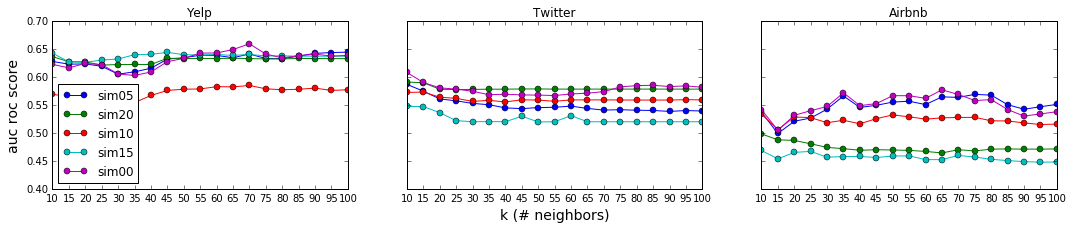

In [182]:
param_eval_knn(project_path,my_method_columns,amt_effect='amt_effect_mostcom',eval_method='roc_auc')

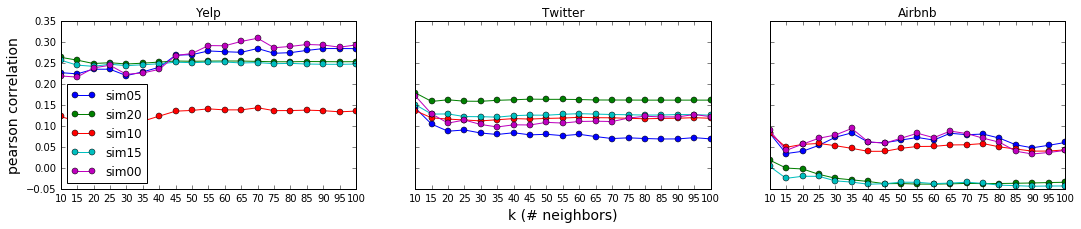

In [183]:
param_eval_knn(project_path,my_method_columns,amt_effect='amt_effect_mostcom',eval_method='pearson')

In [190]:
def param_eval_RF(project_path,flag_method_columns,amt_effect,eval_method):
    """
    Function:
        Calculate how does roc curve (truth=perception, prob=objective) change with different parameters.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18,3), linewidth=2.0, sharex=True, sharey=True)
    
    for ii, data_name in enumerate(['yp', 'tw', 'airbnb']):
        src_tar_df = pd.read_csv(project_path+'V2_'+full_name[data_name].lower()+'/8_Var/'+data_name+'_effect_paramvari.csv')
        truth = np.array([1 if x > 0 else 0 for x in src_tar_df[amt_effect]]) # truth include amt_effect=0
        
        rf_roc = {}
        for mrf in ['vt_effect_varileaf','ctf_effect_varileaf','csf200_effect_varileaf','csf2000_effect_varileaf']:
            rf_df = src_tar_df[mrf].apply(lambda x: x[1:-1].split())
            rf_arr = []
            for row in rf_df:
                row_items = []
                for i in range(len(row)):
                    if(row[i] != 'nan'):
                        row_items.append(float(row[i]))
                    else:
                        row_items.append(0.0)
                rf_arr.append(row_items)
            rf_arr = np.array(rf_arr)
            
            rf_roc[mrf.split('_')[0]]=[]
            for coli in range(rf_arr.shape[1]):
                if(eval_method == 'roc_auc'):
                    rf_roc[mrf.split('_')[0]].append(roc_auc_score(truth,rf_arr[:,coli]))
                elif(eval_method == 'pearson'):
                    rf_roc[mrf.split('_')[0]].append(pearsonr(truth,rf_arr[:,coli])[0])
        
        axes[ii].set_title(full_name[data_name])
        axes[ii].set_xticks([i for i in range(rf_arr.shape[1])])
        axes[ii].set_xticklabels([i for i in range(2, 52, 2)])
    
        for sim in rf_roc:
            axes[ii].plot(rf_roc[sim],marker='o', linestyle='-',label=sim)

    axes[1].set_xlabel('# of minimum samples in leaf node', size=14)
    
    if(eval_method == 'roc_auc'):
        axes[0].set_ylabel('auc roc score', size=14)
    elif(eval_method == 'pearson'):
        axes[0].set_ylabel('pearson correlation', size=14)
    
    axes[0].legend(loc='best')

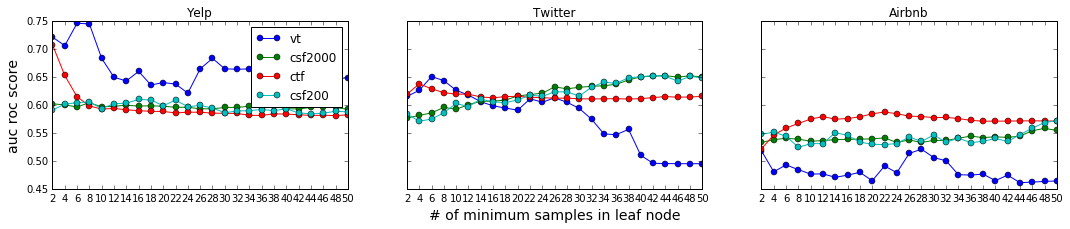

In [188]:
param_eval_RF(project_path,my_method_columns,amt_effect='amt_effect_mostcom',eval_method='roc_auc')

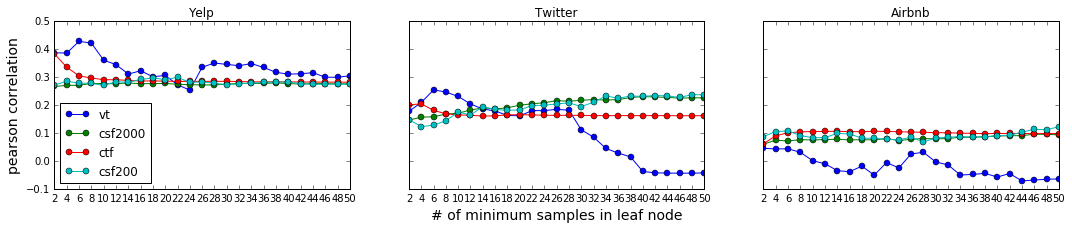

In [191]:
param_eval_RF(project_path,my_method_columns,amt_effect='amt_effect_mostcom',eval_method='pearson')